In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
warnings.resetwarnings()

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# CNN COVID-19 case number forecasting.

## Function definitions

## Data processing and format

## 1-D convolutional models

## Hybrid 1-D + 2-D convolutional models

<img src="files/architecture2.png">

In [2]:
def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

def create_Xy(model_data, start_date, frame_size, n_days_into_future, n_countries):
    # can't include the max date because need at least 1 day in future to predict. +1 because of how range doesn't include endpoint
    for max_date_in_window in range(start_date, model_data.time_index.max() - n_days_into_future + 1):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(model_data.time_index <= max_date_in_window) & (model_data.time_index > max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    y = model_data.new_cases_weighted.values.reshape(-1, model_data.time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y


def split_and_normalize_Xy(X, y, n_time_steps, n_validation_frames, n_test_frames, date_normalization=True,
                          train_test_only=False):
    """ Split into training, validation and test data.
    """
    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
    else:
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]

    X_means = X_train.mean(axis=(1,2))
    X_stds = X_train.std(axis=(1,2))

    # To avoid division by zero. This is a big assumption but this typically occurs when the frame's feature
    # value is identically zero, which would result in x-x_mean / x_std = 0 / 1 = 0. So it doesn't matter what 
    # the x_std value is changed to as they are always divided into 0.
    X_stds[np.where(X_stds==0.)] = 1

#     # First two features are time_index and time_index (days_since_first_case)
    if date_normalization==False:
        X_means[:,:2] = 0
        X_stds[:, :2] = 1

    # To encapsulate the time-dependent nature of the problem and ignore the dramatic difference between current
    # and initial behavior, only rescale the validation and testing frames by the most recent frame's values.
    # There is only a single value per feature in this case, meaning that to rescale, the values need to
    # be repeated for each validation, test frame for each country for each timestep.
    latest_training_mean = X_means[-1,:][np.newaxis, np.newaxis, np.newaxis, :]
    latest_training_std = X_stds[-1,:][np.newaxis, np.newaxis, np.newaxis, :]
    latest_training_std[np.where(latest_training_std==0)] = 1
    
    if train_test_only:
    # Normalize the training data by each frame's specific mean and std deviation. 
        X_train_means = np.tile(X_means[:, np.newaxis, np.newaxis, :],
                                (1, n_countries, n_time_steps, 1))
        X_train_stds =  np.tile(X_stds[:, np.newaxis, np.newaxis, :],
                                (1, n_countries, n_time_steps, 1))                
        X_test_means = np.tile(latest_training_mean, 
                               (X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
        X_test_stds = np.tile(latest_training_std, 
                              (X_test.shape[0],X_test.shape[1],X_test.shape[2],1))   
        
        X_train = ((X_train - X_train_means) /  X_train_stds)
        X_test = ((X_test - X_test_means) /  X_test_stds)
        
        splits =  (X_train, y_train, X_test, y_test)
        normalizing_values = (X_train_means, X_train_stds, X_test_means, X_test_stds)
    else:
        X_train_means = np.tile(X_means[:, np.newaxis, np.newaxis, :],
                                (1, n_countries, n_time_steps, 1))
        X_train_stds =  np.tile(X_stds[:, np.newaxis, np.newaxis, :],
                                (1, n_countries, n_time_steps, 1))                
        X_validate_means = np.tile(latest_training_mean, 
                                   (X_validate.shape[0],X_validate.shape[1],X_validate.shape[2],1))
        X_validate_stds = np.tile(latest_training_std, 
                                  (X_validate.shape[0],X_validate.shape[1],X_validate.shape[2],1))
        X_test_means = np.tile(latest_training_mean, 
                               (X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
        X_test_stds = np.tile(latest_training_std, 
                              (X_test.shape[0],X_test.shape[1],X_test.shape[2],1))    

        X_train = ((X_train - X_train_means) /  X_train_stds)
        X_validate = ((X_validate - X_validate_means) / X_validate_stds)
        X_test = ((X_test - X_test_means) /  X_test_stds)


        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)
        normalizing_values = (X_train_means, X_train_stds, X_validate_means, X_validate_stds,
                              X_test_means, X_test_stds)
                          
    return splits, normalizing_values

def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_test, y_naive, y_predict, title=''):
    fig, axes = plt.subplots(1, 2, figsize=(20,5))
    ymax = np.max([y_test.max(), y_predict.max()])
    axes[0].scatter(y_test, y_naive, s=5)
    axes[0].plot([0, ymax], [0, ymax])

    axes[1].scatter(y_test, y_predict, s=5)
    axes[1].plot([0, ymax], [0, ymax])

    axes[0].set_xlabel('True value')
    axes[0].set_ylabel('Predicted value')
    axes[0].set_title('Naive model')

    axes[1].set_xlabel('True value')
    axes[1].set_ylabel('Predicted value')
    axes[1].set_title('CNN model')
    plt.show()
    return None

def residual_plot(y_test,y_predict,title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
#     plt.show()
    return None

def residual_diff_plots(y_naive, y_predict, y_true, n_test_frames,n_days_into_future, n_countries):
    
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    for i in range(n_test_frames):
        xrange = range(n_countries*i, n_countries*(i+1))
        ax1.plot(xrange, y_true.reshape(-1,n_countries)[i,:]-y_naive.reshape(-1,n_countries)[i,:])
        ax2.plot(xrange, y_true.reshape(-1,n_countries)[i,:]-y_predict.reshape(-1,n_countries)[i,:])
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('True minus Naive baseline')
    ax2.set_title('True minus CNN')
    residual_plot(y_true,y_naive,title='Naive residual',ax=ax3)
    residual_plot(y_true,y_predict,title='CNN residual',ax=ax4)
    plt.show()



def Conv1D_model(X_train,f,k):
    f1, f2 = f
    k1, k2 = k
    
    model = Sequential()
    model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                     padding='valid',
                     input_shape=X_train.shape[1:],
                     activation='relu'
                    )
             )
    model.add(Conv1D(filters=int(f2), 
                     kernel_size=int(k2), 
                     padding='valid',
                     activation='relu'
                    )
             )

    model.add(Flatten())
    model.add(Dense(model.output.shape[1]//2, activation='relu'))
    model.add(Dense(1, activation='relu'))
    return model

def n_step_model_predictions(model_data, model_generator, frame_size, start_date, n_countries,
                             n_validation_frames, n_test_frames, predict_steps, f, k, epochs, batch_size,
                             train_test_only=False, Xy_truncation=None):
    
    """ wrapper for iteration loop 
    
    data : DataFrame of very specific make
    
    model : one of my custom models, sequential_Conv1D_model, SeparableConv2D_model, parallel_Conv1D_model
    
    
    
    """
    new_cases_weighted_index = column_search(model_data,'new_cases_weighted', return_style='iloc')[0]#-n_pruned
    prediction = []
    naive = []
    test = []
    mae_naive_list = []
    mae_predict_list = []
    model_list = []

    for n_days_into_future in predict_steps:
        X, y = create_Xy(model_data, start_date, frame_size, n_days_into_future, n_countries)
        if Xy_truncation is not None:
            X = X[:Xy_truncation,:,:,:]
            y = y[:Xy_truncation,:]
        splits, normalizing = split_and_normalize_Xy(X, y,frame_size, n_validation_frames,
                                                     n_test_frames,train_test_only=train_test_only)
        A_splits = concatenate_4d_into_3d(splits, train_test_only=train_test_only) 
        
        if model_generator == SeparableConv2D_model:
            B_splits = splits
            if train_test_only:
                X_train_A, y_train_A, X_test_A, y_test_A = A_splits
                X_train_B, y_train_B, X_test_B, y_test_B = B_splits
                
                # model building
                X_train = [X_train_A, np.tile(X_train_B, (n_countries, 1,1,1))]
                y_train = y_train_A
                X_validate = [X_test_A, np.tile(X_test_B, (n_countries, 1,1,1))]
                y_validate = y_test_A
                X_test = [X_test_A, np.tile(X_test_B, (n_countries, 1,1,1))]
                y_test = y_test_A
            else:
                X_train_A, y_train_A, X_validate_A, y_validate, X_test_A, y_test_A = A_splits
                X_train_B, y_train_B, X_validate_B, y_validate, X_test_B, y_test_B = B_splits  
                X_train = [X_train_A, np.tile(X_train_B, (n_countries, 1,1,1))]
                y_train = y_train_A.ravel()
                X_validate = [X_validate_A, np.tile(X_test_B, (n_countries, 1,1,1))]
                y_validate = y_test_A.ravel()
                X_test = [X_test_A, np.tile(X_test_B, (n_countries, 1,1,1))]
                y_test = y_test_A.ravel()
        else: 
            if train_test_only:
                X_train, y_train, X_test, y_test = A_splits
                X_validate, y_validate = X_test, y_test
            else:
                X_train, y_train, X_validate, y_validate, X_test, y_test = A_splits

                

        model = model_generator(X_train, f, k)
        model.compile(loss='mae', optimizer='adam')
        # fit network
        history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_validate, y_validate), 
                  batch_size=batch_size)
        
        ### analysis
        y_test = y_test.ravel()
        y_naive = X[-n_test_frames:, :, -1, new_cases_weighted_index].ravel()
        y_predict = model.predict(X_test).ravel()
        # evaluate model

        mae_naive = mean_absolute_error(y_test, y_naive)
        mae_predict = mean_absolute_error(y_test, y_predict)
        r2_naive = explained_variance_score(y_test, y_naive)
        r2_predict = explained_variance_score(y_test, y_predict)
        mae_naive_list.append(mae_naive)
        mae_predict_list.append(mae_predict)
        model_list.append(model)
        print('{}-step MAE [Naive, CNN] = [{},{}]'.format(
        n_days_into_future, mae_naive, mae_predict))
        print('{}-step R^2 [Naive, CNN] = [{},{}]'.format(
        n_days_into_future, r2_naive, r2_predict))
        
        true_predict_plot(y_test, y_naive, y_predict, title='')
        residual_diff_plots(y_naive, y_predict, y_test, n_test_frames, n_days_into_future, n_countries)
        
    return test, naive, prediction, mae_naive_list, mae_predict_list, model_list

## Data processing

In [3]:
# Import cleaned data produced by other notebook. 
data = pd.read_csv('cnn_data.csv',index_col=0)

A quick synopsis of the data. This data contains time series data for 10 features for 103 separate countries Because of how unfairly very small countries are weighted, the countries smaller than 25th percentile of population were removed.

First course of action is to decide on the format of the inputs. For now, focus on 1-D convolution only.
Need to decide on the dimension of the inputs. The typical format is (batch size, time steps, n_features). 
Two quick ideas :

I think the simplest is to just find all windows of length $n$ for all countries such that the input dimension would be
input_dim = (n_countries * n_windows, window_size, n_features) 

The other idea I had would be to do (n_windows, n_countries, window_size, n_features), and then the output would be the future values for each country.

Just do the first for now. Also, just do a one-step model for now.

Want to predict n_cases_weighted (weighted by the percentage of the population that the country consists of. Might be a dumb idea.)

In [4]:
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date', 'new_recovered_weighted'])
# this is just a convenience thing for slicing later on.
data.loc[:, 'time_index'] += 1

In [5]:
n_countries = data.location.nunique()
n_dates = data.time_index.nunique()

In [6]:
n_countries

103

In [7]:
X, y = create_Xy(model_data, start_date, frame_size, n_days_into_future, n_countries)

NameError: name 'model_data' is not defined

By iterating over possible leading window dates (window right edge, not inclusive),
a 4-d tensor with dimensions given by the following is created:
    
```(n_windows, n_countries, n_time_steps, n_features)```

Even if I don't use the input of this form, it makes it much easier to slice into train, validate and test, by slicing along
the ```n_windows``` axis. 

Note that if I also only wanted to include data from after the first case, that is possible by slicing data.time_index >= 1 

Putting this all together:


Now, splitting X intro train, validate, test, is as easy as slicing the first axis. Depending on how the CNN is set up, this
axis can later be flattened by simply applying ```np.concatenate(X_train, axis=0)```

Now, for the target data ```y```. To be as general as possible, I note that I should first shift the time series and combine them to store all of the data, and THEN manipulate it, i.e.

Assuming that ```X``` is of the shape ```(n_windows, n_countries, n_time_steps, n_features)```, the target data ```y``` should
be of shape ```(n_windows, n_countries)``` and the values for each slice of the first axis is then of shape ```(n_countries,)```, with the values equaling the ```model_data.n_cases_weighted``` value for ```time_index == window_right_edge_inclusive + n```, where n is the prediction step size. 

Because we need future values with which to measure error, the maximum that the leading window edge can be is always 

```model_data.time_index.max() - n```

In other words, because the maximum date value is

If I want to predict (and measure error) for 7 days in the future, the last window would have leading edge 
```model_data.time_index == 123```. 

For now, just test the waters with a 1-day prediction.
To do so, first split the X and y data into train, validate, test.
For the first attempt at a model, use Conv1D only, have to flatten the data with concatenations.
Before this, however, I want to rescale the data. Now, because each different element in the first axis is a different time range, the correct action is to (if normalizing) take the mean with respect to axis=1 and axis=2 ```n_countries``` and  ```n_time_steps```. This leaves a total number of averages of shape ```(n_windows, n_features)```, i.e. the mean and standard deviations for each feature for each date range. This ensures that no data snooping has occurred. To actually subtract and divide by these values, need to reform the same shape array (or at least that seems to be the easiest method to me.

Just to check, the slice [0, :, :, 0] should only contain one value.

Need to normalize only using the values up until frame; in fact, I only use the values inside each frame to normalize.
In the case of normalizing the validation and testing sets, use the most recent frame's means and standard deviation to normalize. This requires forming the correctly shaped array which is performed using np.tile()

Unfortunately there are values (actually a single value) where the standard deviation equals 0. Luckily, this
can be circumvented because the value of $X-\bar{X}$ is zero in the same place; i.e. I set $\sigma=1$ at that location, because
it doesn't actually affect the value.

Notes on results

    1. kernel small->large seems to work ok.
    2. filters
    3. pooling seems to hurt.

Create a 5-d tensor for convolution and FC layer parameters using itertools.
The layers of the CNN will remain the same throughout testing for now. That is, 

    1. Conv1D(f1, k1)
    2. Conv1D(f2, k2)
    3. Flatten
    4. Dense(d)
    5. Dense(1)) 

I don't know enough yet, but my intuition tells me that the overall trend (macroscopic picture)
is much more important to capture than microscopic. 
   
    f1 : number of filters,  first convolutional layer
    k1 : kernel size, first convolutional layer
    f1 : number of filters,  second convolutional layer
    k1 : kernel size, second convolutional layer
    d : number of nodes in hidden fully connected layer
    

I believe the naive baseline is performing so much better simply because of the growth in number of new cases; i.e. the model is training on smaller values and so in every prediction its underestimating. It's also predicting nearly the same values for each separate validation date, likely indicative of overfitting. 

Changing the activations and the layers seems to work much better than the number of filters and kernel size.

ReLU activation on both cd layers somehow increases the values, i.e. away from zero? how does that make sense.
Predicting non-negative quantity -> ReLU at eachy layer, otherwise model will try to use negative values which never do anything?

On the surface this performs worse but doesn't look like it's making ***terrible*** predictions. I'll show that I believe
that the model is indeed over-fitting. 

Relation between X slicing and the original data: 

    X[-1, :, -1, 2] = model_data.time_index.max() - n_days_into_future 
    X[-t, :, -1, 2] = (model_data.time_index.max() - n_days_into_future + 1) - t


In this case, the "last" date of X_validate corresponds to t = 2.

In [55]:
X, y = create_Xy(model_data, start_date, frame_size, n_days_into_future, n_countries)

### Data Format

By iterating over possible leading window dates (window right edge, not inclusive),
a 4-d tensor with dimensions given by the following is created:
    
```(n_windows, n_countries, n_time_steps, n_features)```

Even if I don't use the input of this form, it makes it much easier to slice into train, validate and test, by slicing along
the ```n_windows``` axis. 

Note that if I also only wanted to include data from after the first case, that is possible by slicing data.time_index >= 1 

Putting this all together:


In [57]:
print(X.shape) 
print(y.shape)

(51, 103, 32, 9)
(51, 103)


In [59]:
t = (n_validation_frames + n_test_frames)
(X[-t, :, -1, new_cases_weighted_index] - model_data[model_data.time_index == ((model_data.time_index.max() - n_days_into_future + 1) - t)].new_cases_weighted).sum()

0.0

And so to test the baseline, the predictions are of course the date on the RHS + n_days_into_future, or 

In [60]:
# ((- n_days_into_future + 1) - t)
# + 1 - (n_validation_frames + n_test_frames)
# ((model_data.time_index.max() + 1) - n_test_frames)
# ((model_data.time_index.max() + 1) - (n_validation_frames + n_test_frames))

129

I'm going to guess that this is overfitting; this could not have been seen if n_validation_frames == 1.

The CNN predictions barely change day-to-day. To quantify this, look at the pairwise RMSE error between successive predictions.

This proves the case where n_validate_frames == 1. Now try it for 7. This means that the "first" validation frame is t==8

Ok. Now to see if the baseline is actually what I think it is. There could be an issue into how I am calculating the loss.
This is calculating the loss of all batch frames simulataneously...? Each frame for each country makes a single prediction.
Should I be trying to group it only by frame though? I.e. 2-d input. 

In [62]:
y_naive = X[-n_test_frames-1, :, -1,  new_cases_weighted_index]

In [64]:
y - create_Xy(model_data, start_date, frame_size, n_days_into_future, n_countries)[1][-y.shape[0]:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Somehow the relation between X and y is upheld (because of for loop?) they are not changing between n_days_into_future_changes. 

Emulate the last iteration of for loop.

What should be going on. For n_days_into_future = 7, X should be slicing data from time <= 123

Then, the data is reshaped to be an iterable of sequences of length max_date_in_window, which is then truncated.

For y. What should be happening? 

X is made such that its maximum date is  ```model_data.time_index.max() - n_days_into_future```. So by the very creation of
X, X and y are already staggered if y is sliced correctly. Which would be ```start_date + n_days_into_future : ```, or simply ```-X.shape[0]:```

X_test is the last frame. meaning that it currently contains t-14 information. y_test is the very last day, n_cases_per_million
un-normalized, so the naive model would be simply to use y_predict = X_test_original[:, -1, 2], this takes the values of the feature, new_cases_per_million, on the last day of the frame, for all countries.

SeperableConv2D model. I believe that time steps should be channels and then countries should be the rows...

Suprisingly, my first guess at the parameters was very close to the optimal setup.

In [26]:
# print('The top 10 sets of parameters (k1,k2,f1,f2,d) are:\n')

# mae_rankings = pd.DataFrame(np.concatenate((parameter_grid[mae_list.argsort()],mae_list[mae_list.argsort()].reshape(-1,1)),axis=1), 
#              columns=['kernel_layer_1','kernel_layer_2','filter_layer_1','filter_layer_2','MAE'])
# mae_rankings.head()


In [68]:
# mae_rankings.to_csv('conv_parameter_rankings.csv')

# best_param_predictions = predictions_list[mae_list.argsort()][0]

# pd.DataFrame(predictions_list[mae_list.argsort()]).to_csv('model_param_grid_predictions.csv')

In [ ]:
# pd.read_csv('conv_parameter_rankings.csv', index_col=0)

Because ```n_days_into_future == 1```, The most recent date in the last frame of X is data.time_index.max()-1.
The maximum date in y is data.time_index().max(). Therefore, to convert, we have
    
    X[-1,:,-1,:] = y[-2, :]
    
or, more generally, 

    X[-t,:,-1,:] = y[-(n+t), :]
    
testing this:

In [67]:
#  X[-16:, :, -1, new_cases_weighted_index].shape

In [66]:
# last_day_in_X = -1
# if last_day_in_X == -1:
#     last_day_in_X = None
# X_test_original = X[-16:last_day_in_X, :, -1, new_cases_weighted_index] 
# if last_day_in_X is None:
#     last_day_in_X = 0

# X_test_original - y[-(n_test_frames+n_days_into_future+X_test_original.shape[0]+last_day_in_X-1):
#                     -(n_days_into_future+last_day_in_X), :]

This shows that the staggering has been done correctly. That is, each entry along the first axis of X predicts.
Need to make sure that the naive predictions are being chosen correctly. To do so, just look at the instance
where n_frames_validation == 1 and n_frames_test == 1 (to make slicing easier) for n_days_into_future == 7.

Specifically, the shifting and comparison between y_validate and X_train isn't so hard as it follows the above formula.
This is prior to concatenation / squeezing / flattening the first axis.

    The following holds but this is not the predictions relation:   X[-t,:,-1,:] = y[-(n+t), :]
                                                  
    y has already been shifted to account for the n_days_into_future prediction. Therefore,     
    True future new_cases_weighted values : y[-t,:]. This is the n_days_into_future values.
    
    CNN predictions new_cases_weighted : model.predict(X[-t, :, :, :]). This predicts using the "present day" frame. 
    
    Naive predictions new_cases_weighted values: X[-t,:,-1, 2]. This takes the present day value from the last values of the frames.

Therefore, when n_validation_frames > 1.  are simply

    Naive predictions = X[validation_indices, :, -1, 2]
    CNN predictions = model.predict(X[validation_indices, :, :, :])
    True future values = y[validation_indices, :]
    
    Where validation indices is assumed to be a correctly formatted array of negative indices. 
    
    
    The last issue is the fact that X_validate is normalized and y values are not. Therefore, for the prediction X_validate is used, but for the naive baseline either the inverse normalized X_validation or just the original X should be used. Original
    X is actually easier because of 4-d index.

First, train and "test" without using the holdout test set. i.e. just use train and validation sets to test
This uses a single frame to validate (and test). Therefore, the naive model is formed by taking the frame of
X_validate and using its values for the prediction. The true values are stored in y_validate, the predicted values
are formed by using X_validate to predict, the naive values are the values in X_validate. 

Remember when slicing, the n_days_into_future buffer has already been factored into account. i.e. test
slicing is X[-n_test_frames:,:,:,:]

X time_index 130 is not used. X_test is 129, y_test is 130. X_validate is 126,127,128 y is 127,128,129.

from https://papers.nips.cc/paper/7320-how-many-samples-are-needed-to-estimate-a-convolutional-neural-network.pdf

To achieve error $\epsilon$ with filter number $m$ the number of samples needed is $\mathcal{O}(m/\epsilon^2)$

Let $\epsilon = 0.1$, then $100m$ = samples. The number of samples I have is fixed however, so reverse engineer $m$.

It seems that included information from the too distant past actually makes the model worse. 

Train on 6283 samples, validate on 309 samples
Epoch 1/3
6283/6283 [==============================] - 3s 524us/sample - loss: 7.6035 - val_loss: 7.4092
Epoch 2/3
6283/6283 [==============================] - 1s 183us/sample - loss: 5.0644 - val_loss: 6.9683
Epoch 3/3
6283/6283 [==============================] - 1s 172us/sample - loss: 4.7656 - val_loss: 6.6101
1-step MAE [Naive, CNN] = [6.54660398756923,6.6100597576991715]
1-step R^2 [Naive, CNN] = [0.530807245534921,0.7259570664430814]


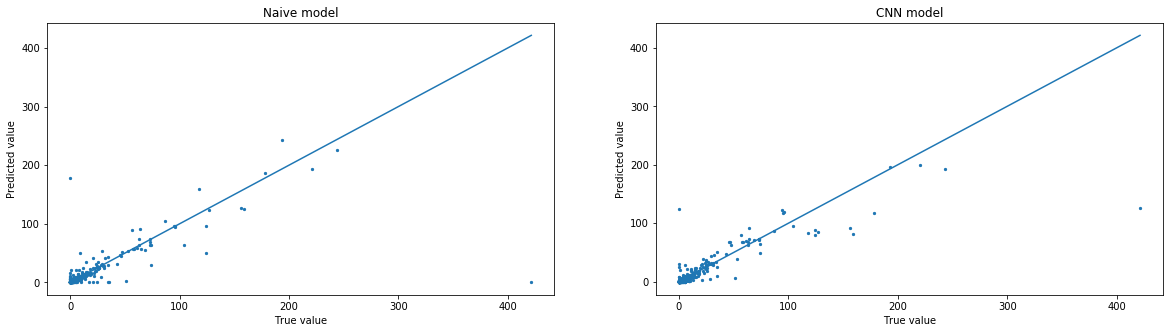

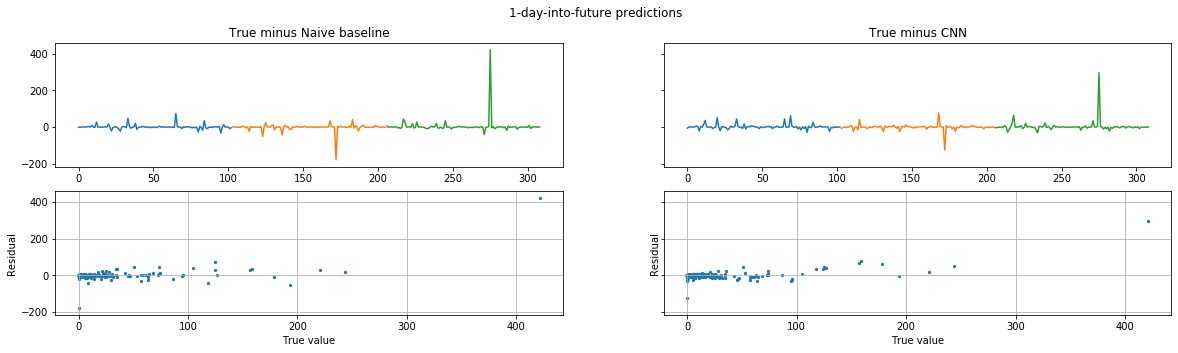

Train on 5665 samples, validate on 309 samples
Epoch 1/3
5665/5665 [==============================] - 3s 563us/sample - loss: 9.3215 - val_loss: 9.0329
Epoch 2/3
5665/5665 [==============================] - 1s 174us/sample - loss: 6.8499 - val_loss: 8.8739
Epoch 3/3
5665/5665 [==============================] - 1s 173us/sample - loss: 6.2107 - val_loss: 8.0059
7-step MAE [Naive, CNN] = [7.1172961387508025,8.005861383445488]
7-step R^2 [Naive, CNN] = [0.7238952116794292,0.6697440303041329]


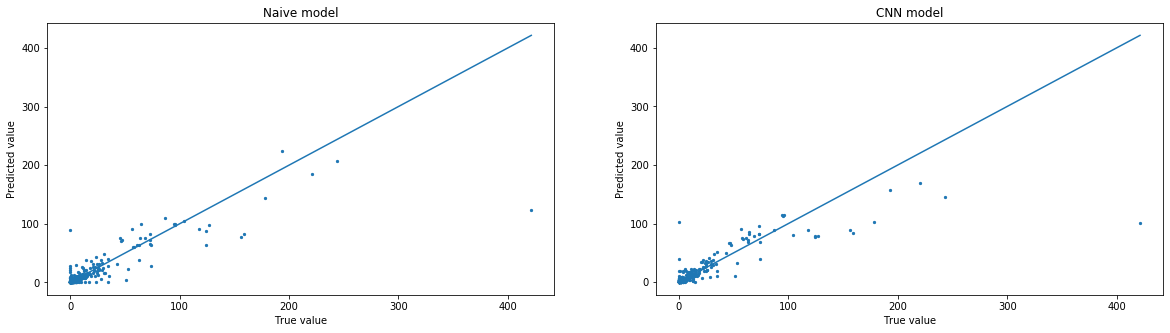

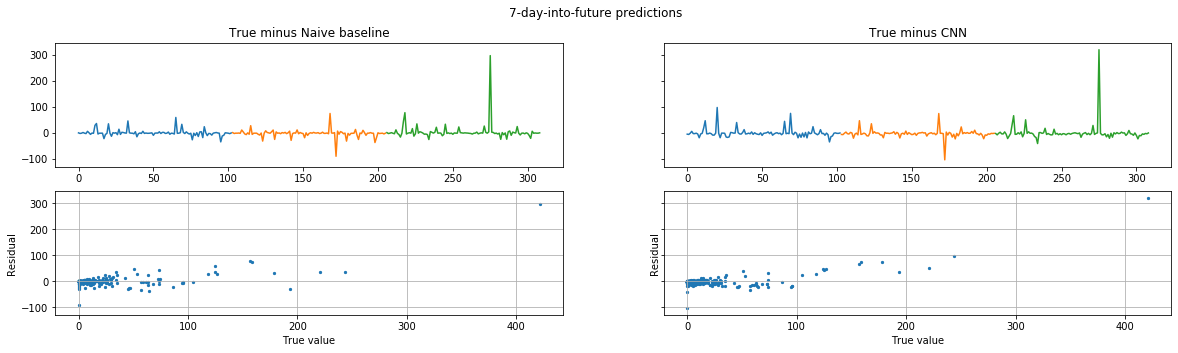

Train on 4944 samples, validate on 309 samples
Epoch 1/3
4944/4944 [==============================] - 3s 644us/sample - loss: 11.0028 - val_loss: 10.8159
Epoch 2/3
4944/4944 [==============================] - 1s 182us/sample - loss: 8.2318 - val_loss: 9.1956
Epoch 3/3
4944/4944 [==============================] - 1s 175us/sample - loss: 7.3144 - val_loss: 9.3381
14-step MAE [Naive, CNN] = [8.92361200888498,9.33814638660719]
14-step R^2 [Naive, CNN] = [0.6200592436885759,0.4810109121104643]


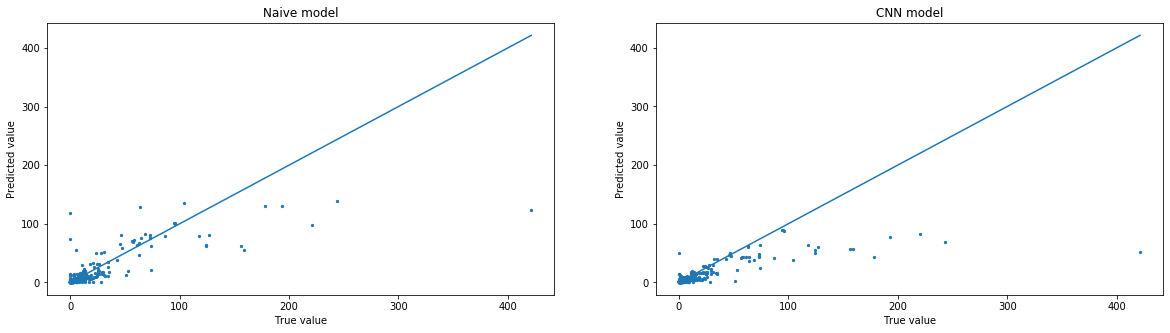

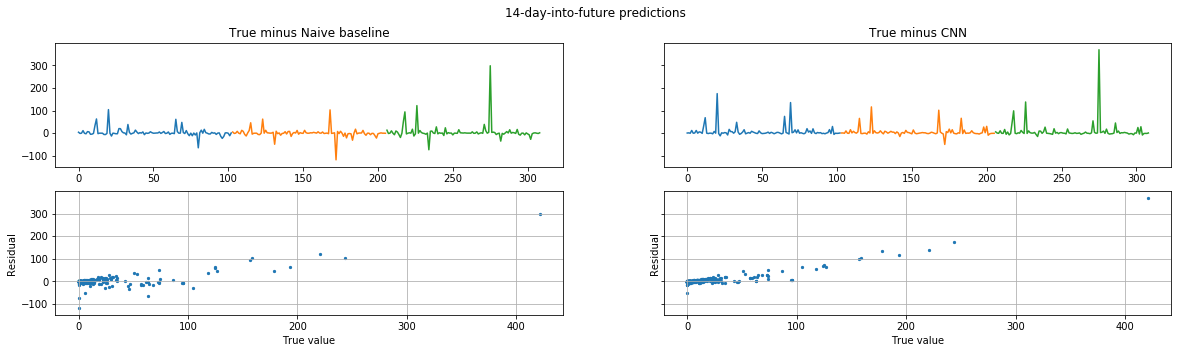

In [46]:
model_data = data.iloc[:,1:]
model_generator = Conv1D_model

frame_size = 32
# start_date = frame_size + model_data.time_index.min()
start_date = data.time_index.max() - 2 * frame_size

n_validation_frames = 1
n_test_frames = 3
predict_steps = [1, 7, 14]
f = (8, 16)
k = (4, 4)
epochs = 3
batch_size = 32
train_test_only = True

results = n_step_model_predictions(model_data, model_generator, frame_size, start_date, n_countries,
                             n_validation_frames, n_test_frames, predict_steps, f, k, epochs, batch_size,
                             train_test_only=train_test_only)
test, naive, prediction, mae_naive_list, mae_predict_list, model = results

# The more complex 1-D model

Convolve a single input in parallel, using different kernel sizes. 
Send the same input to different kernel-size convolutional layers before aggregating. 
architecture from https://www.youtube.com/watch?v=nMkqWxMjWzg

    different kernel sizes the entire point
    combinations tested: 
    
    1. equal filters
    2. weighted n_filters
    3. pooling (not good)
    4. dilation (not good)
    5. invidual dense layers on top of last 2 FC layers
    6. 
                    
    

Train on 6283 samples, validate on 309 samples
Epoch 1/3
6283/6283 [==============================] - 10s 2ms/sample - loss: 6.3318 - val_loss: 7.3470
Epoch 2/3
6283/6283 [==============================] - 6s 927us/sample - loss: 4.8508 - val_loss: 6.6789
Epoch 3/3
6283/6283 [==============================] - 6s 927us/sample - loss: 4.3056 - val_loss: 6.7560
1-step MAE [Naive, CNN] = [6.54660398756923,6.755962801733062]
1-step R^2 [Naive, CNN] = [0.530807245534921,0.714555211764677]


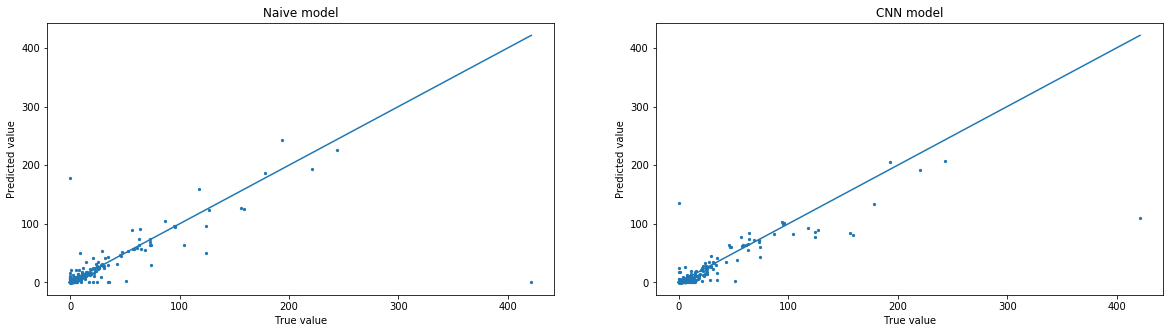

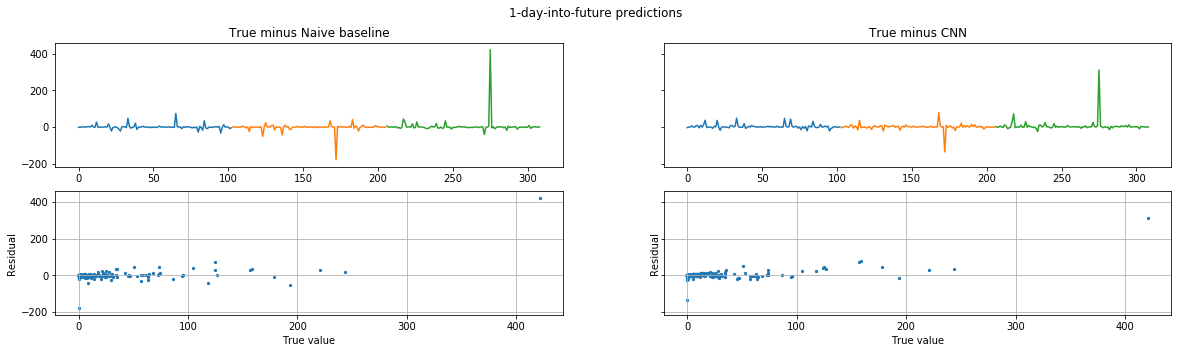

Train on 5665 samples, validate on 309 samples
Epoch 1/3
5665/5665 [==============================] - 10s 2ms/sample - loss: 7.7508 - val_loss: 9.1755
Epoch 2/3
5665/5665 [==============================] - 5s 937us/sample - loss: 6.1793 - val_loss: 8.0497
Epoch 3/3
5665/5665 [==============================] - 5s 931us/sample - loss: 5.3913 - val_loss: 8.1922
7-step MAE [Naive, CNN] = [7.1172961387508025,8.192212817386638]
7-step R^2 [Naive, CNN] = [0.7238952116794292,0.5871625960875317]


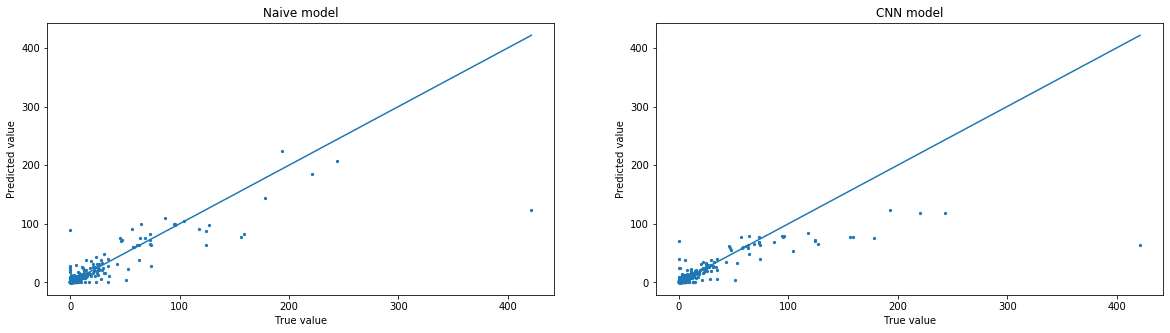

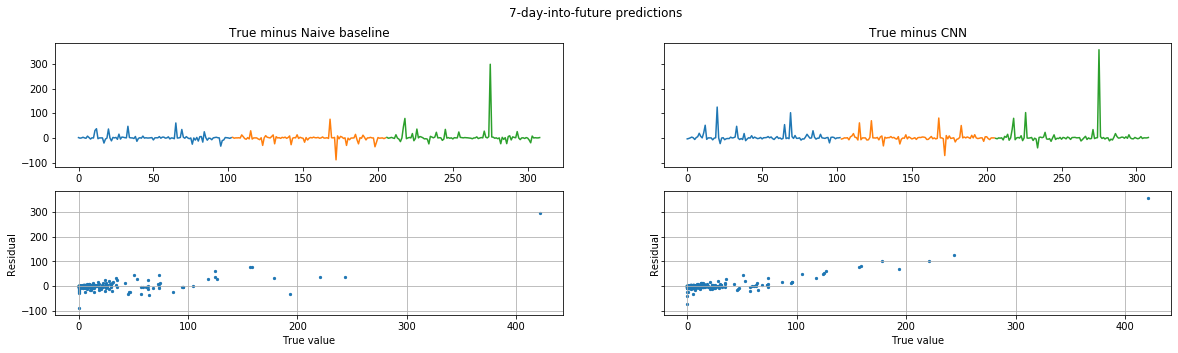

Train on 4944 samples, validate on 309 samples
Epoch 1/3
4944/4944 [==============================] - 9s 2ms/sample - loss: 9.9005 - val_loss: 10.6099
Epoch 2/3
4944/4944 [==============================] - 5s 962us/sample - loss: 7.3777 - val_loss: 10.1288
Epoch 3/3
4944/4944 [==============================] - 5s 930us/sample - loss: 6.6184 - val_loss: 9.4156
14-step MAE [Naive, CNN] = [8.92361200888498,9.415581943514102]
14-step R^2 [Naive, CNN] = [0.6200592436885759,0.5030724113176588]


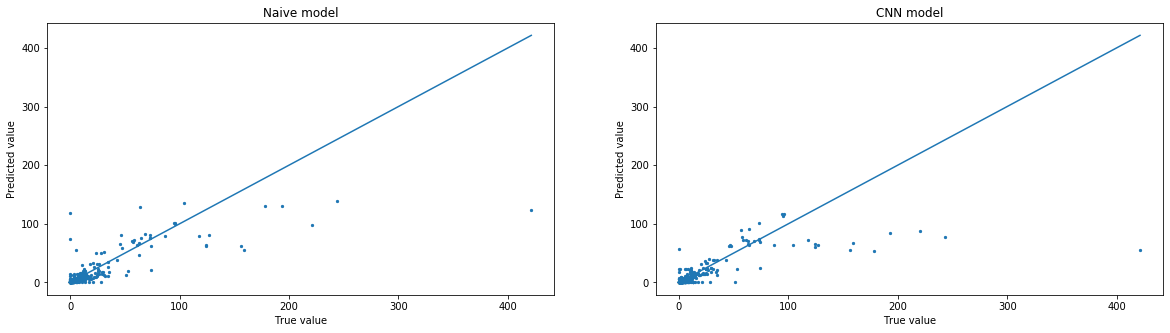

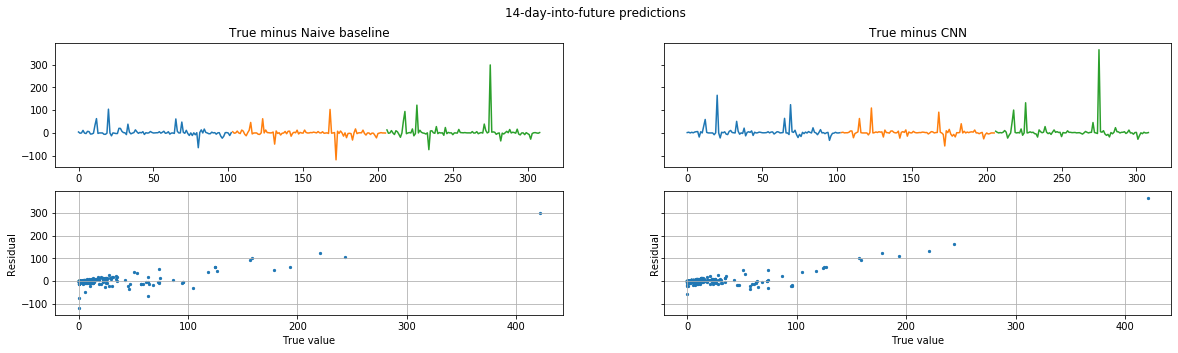

In [70]:
model_data = data.iloc[:,1:]

frame_size = 32
start_date = n_dates - 2 * frame_size

k = 1,2,3,4,5,6
# first 6 values are first each of the first parallel layer, last 6 are second parallel layer.
# f = (4,4,4,4,4,4,8,8,8,8,8,8)
f = (8,8,8,8,8,8,16,16,16,16,16,16)

n_validation_frames = 1
n_test_frames = 3
epochs = 3
batch_size = 32
predict_steps = [1, 7, 14]
naive_scores = []
predict_scores = []
train_test_only=True
model_generator = parallel_Conv1D_model
results = n_step_model_predictions(model_data, model_generator, frame_size, start_date, n_countries,
                             n_validation_frames, n_test_frames, predict_steps, f, k, epochs, batch_size,
                             train_test_only=train_test_only)
test, naive, prediction, mae_naive_list, mae_predict_list,model = results

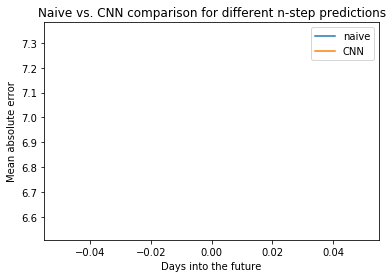

In [36]:
# fig = plt.figure()
# _ = plt.plot(mae_naive_list, label='naive')
# _ = plt.plot(mae_predict_list,label='CNN')
# _ = plt.ylabel('Mean absolute error')
# _ = plt.xlabel('Days into the future')
# _ = plt.title('Naive vs. CNN comparison for different n-step predictions')
# _ = plt.legend()
# _ = plt.show()

For SeperableConv2D needs to be organized in ```(batch_size, channels, rows, cols)``` is ``` data_format='channels_first'``` (not default)

The main worry is that the number of samples is very low....  maybe change input_shape = (None, 103, 10) and generate more windows and frames? the problem; would have to pad or truncate such that they're all 32 in length. Truncation would introduce redudant data and 

Original code:

Indeed I was correct about having pairwise samples. There for I need a copy of each frame for the number of countries. but these still need to be time ordered correctly. The input A is formatted as such

    [Country 0, Frame 0, :]
    [Country 0, Frame 1, :]
    ...
    [Country 0, Frame N, :]
    [Country 1, Frame 0, :]
    [Country 1, Frame 1, :]
    ...
    [Country 1, Frame N, :]
    
Therefore the correct time ordering is made by simply tiling input B along its first  axis (axis=0)

The idea is to create a predictive model with two components, the first just takes input wherein each sample is a single
frame from a single country. The second input is a 2D convolution which takes the same frame from all countries. 
I need to make sure that the inputs are synchronized but I don't know how to check this. Maybe the output

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

"The branches work independently until they are concatenated. This seems to imply that the batch sizes need to be the same,
which would require a repetitition of the Conv2D tensor so that the batches equal. i.e. I would need to create a copy of the 2D data for each country so that each single-country-single-frame in inputA would be paired. Also, what am I predicting for the output. I believe that need to set it up for a single number. I.e. input A takes a single-country-single-frame, imbuing the model with knowledge of a single time series while the 2D input "shares" knowledge between countries at the same moment in time. Perhaps I should make it simply a 1-D convolution over the countries over a single day, namely, the latest data?

maybe I should actually be convolving countries first, and then time. i.e. do not need transposition. 

filters have to be the same, so that output dimensions are the same?

Original method just convolved individually and then flattened; this doesn't combine the information, instead,
concatenate and then do ANOTHER SeparableConv2D. This convolves the specific (convolved) country frame with the 2D countries+frame convolved data.

The convolution has not been doing what I thought it was doing all along. The "features" are the channels. Not the time steps or countries. I.e. for EACH FEATURE, the country and time axes are convolved. This constitutes an "output". I.e. for each filter there are 10 (n_features) outputs. These 10 outputs are then convolved with a pointwis convolution. 

I.e. I was right about the n_countries being the "channels" but for the wrong reason. In fact, I don't even know if I actually want a 2D convolution. This mixes the feature data together. 

2 ideas.
I know I want to convolve along the time axis and I do not want to the features to communicate (this will 

How to capture time trends: have a time index. Do not mix the feature data; i.e. the trend is captured by the temporal
convolution of the time index; but the filter 

So, each feature is convolving along the time axis and then the country axis. This means that for the time_index feature, 
this convolves the sequence [1,2,3,4,5,6,...] and then uses that result and convolves it with copies. creating a rectangle
of identical rows. (if time is columns). then, this is pointwise convolved with the other features. 

If the channels are the features, then the ordering of the countries matters. therefore the channels have to be the countries,
but this will make the order of the features matter. The way of getting around this is to make the kernel size == the span of
the dimension, then only 1 convolution is computed which includes either all countries or all features. ...

I believe that I do care about mixing feature information but I do not care about mixing time or country information, actually the country mixing is the entire points. s

Axes that do not have a well defined order (i.e. countries and features) have to be convolved with kernel == n_features (or countries, respectively). Otherwise, the order of the features and countries will matter. Because this reduces the dim from n_features (or n_countries) -> 1 it's important to take a large number of filters. 

I believe I was mistaken with how Conv1D actually works. i.e. if I give Conv1D a time series of n features, then how does data of dimension ```(n_steps, n_features)``` reduce to ```(n_steps, n_filters)```??? In other words, I didn't think the feature data was being mixed but it seems I am wrong.

Each channel (feature) has its own weight. I believe at least. Therefore, I should indeed be doing channels last. Now, whether to do time or countries first still needs to be determined.

This is determined by how it interacts with the other input. Namely, there is a single country time series (with multiple features) being input. Now, 

What I ***know*** is that the convolution kernel for countries has to be n_countries large otherwise the order matters.


# Parallel (1+2) D model

Thoughts: the more I'm training to more that the performance simply approaches the baseline model, as it's overtraining on the "present" values

Train on 9682 samples, validate on 309 samples
Epoch 1/3
9682/9682 [==============================] - 16s 2ms/sample - loss: 6.1098 - val_loss: 8.3958
Epoch 2/3
9682/9682 [==============================] - 11s 1ms/sample - loss: 4.4827 - val_loss: 7.8683
Epoch 3/3
9682/9682 [==============================] - 11s 1ms/sample - loss: 4.0670 - val_loss: 7.7243
1-step MAE [Naive, CNN] = [6.54660398756923,7.7243415561806215]
1-step R^2 [Naive, CNN] = [0.530807245534921,0.6716948523768284]


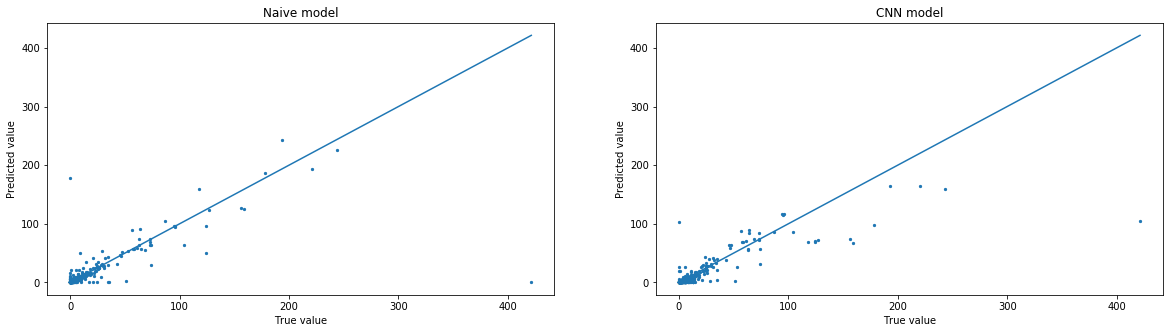

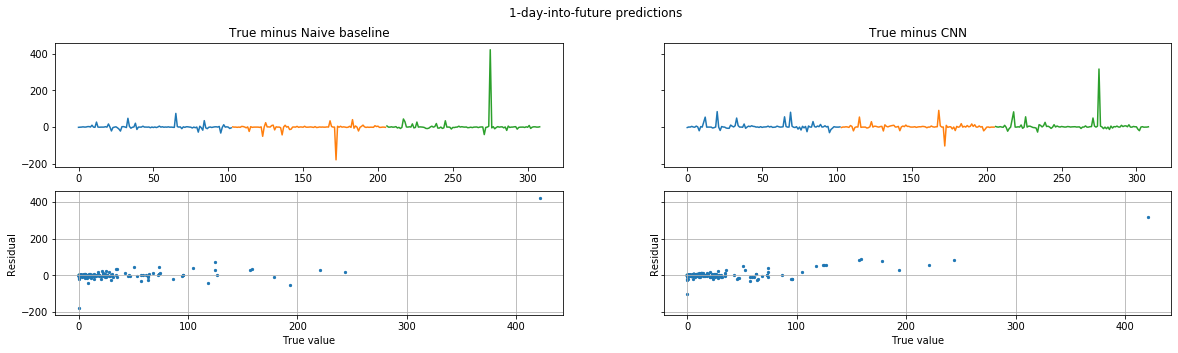

Train on 9064 samples, validate on 309 samples
Epoch 1/3
9064/9064 [==============================] - 15s 2ms/sample - loss: 7.2613 - val_loss: 10.6227
Epoch 2/3
9064/9064 [==============================] - 10s 1ms/sample - loss: 5.5434 - val_loss: 9.5058
Epoch 3/3
9064/9064 [==============================] - 10s 1ms/sample - loss: 5.1543 - val_loss: 8.8714
7-step MAE [Naive, CNN] = [7.1172961387508025,8.871404835455944]
7-step R^2 [Naive, CNN] = [0.7238952116794292,0.5502846017649221]


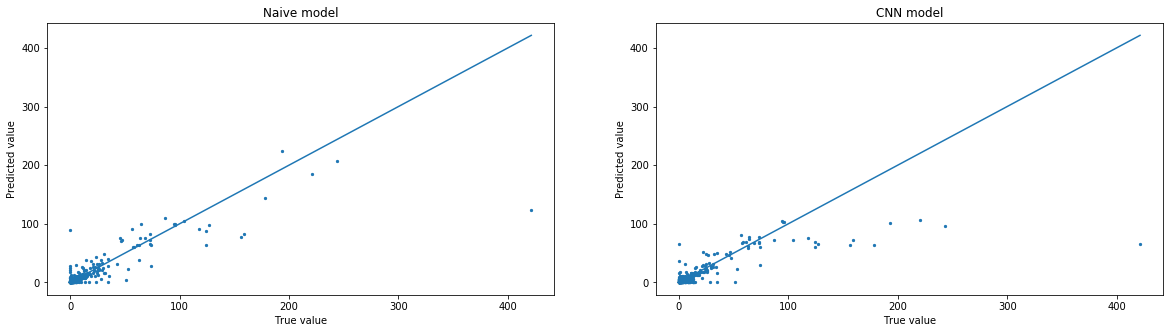

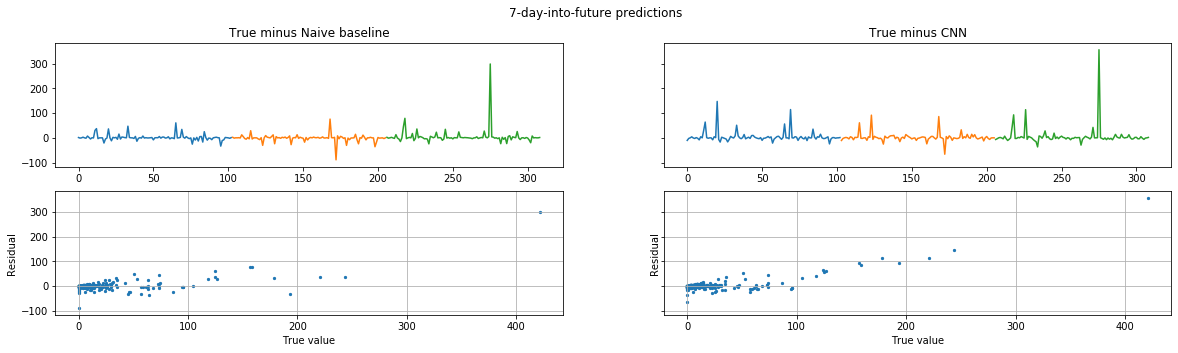

Train on 8343 samples, validate on 309 samples
Epoch 1/3
8343/8343 [==============================] - 14s 2ms/sample - loss: 9.0240 - val_loss: 13.0628
Epoch 2/3
8343/8343 [==============================] - 10s 1ms/sample - loss: 7.1562 - val_loss: 10.9223
Epoch 3/3
8343/8343 [==============================] - 10s 1ms/sample - loss: 6.5650 - val_loss: 10.0055
14-step MAE [Naive, CNN] = [8.92361200888498,10.005512887378037]
14-step R^2 [Naive, CNN] = [0.6200592436885759,0.46319741827344085]


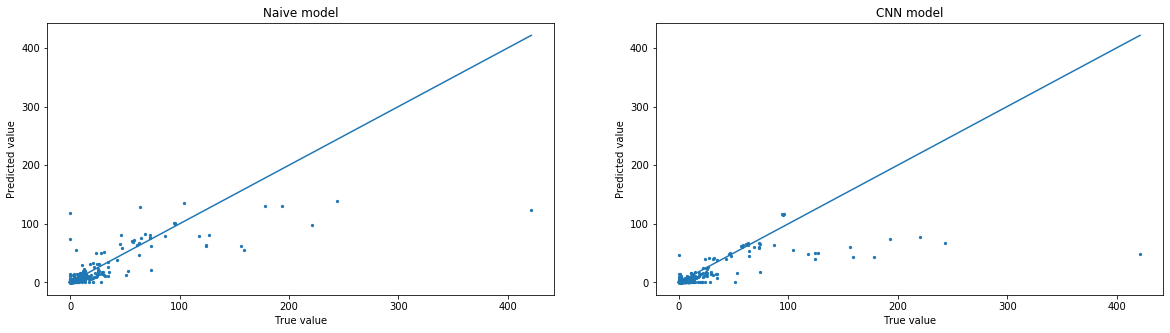

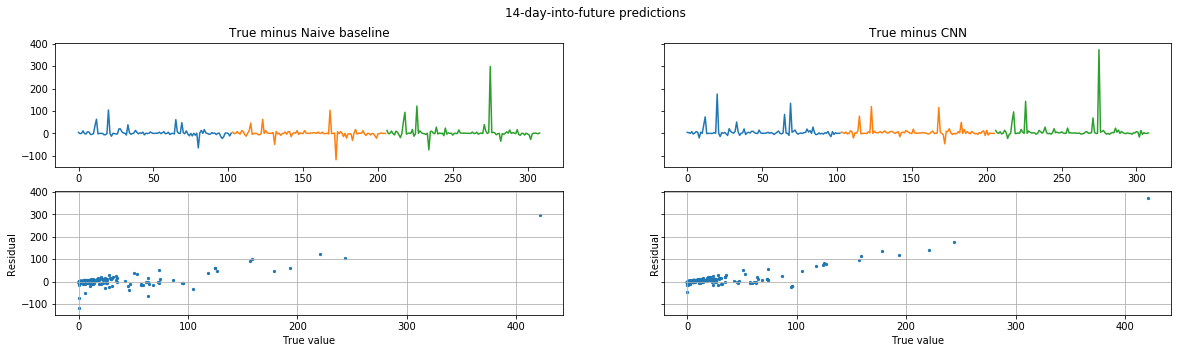

In [71]:
model_data = data.iloc[:,1:]

fA = 16
fB = 16
kA = 4
kB = 4
fAB = 32
kAB = 4

f = (fA, fB, fAB)
k = (kA, kB, kAB)

epochs = 3
batch_size = 32

frame_size = 32
start_date = frame_size + model_data.time_index.min()
n_validation_frames = 1
n_test_frames = 3
predict_steps = [1,7,14]

model_generator = SeparableConv2D_model
results = n_step_model_predictions(model_data, model_generator, frame_size, start_date, n_countries,
                             n_validation_frames, n_test_frames, predict_steps, f, k, epochs, batch_size,
                             train_test_only=True)

test, naive, prediction, mae_naive_list, mae_predict_list, model = results

switching the order of countries and timesteps affects the following:
reshape A
kernel size B
kernal size AB
concatenate axis 1->2

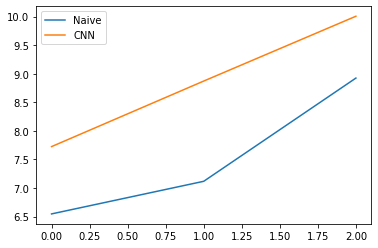

In [75]:
plt.plot(mae_naive_list,label='Naive')
plt.plot(mae_predict_list,label='CNN')
plt.legend()
plt.show()

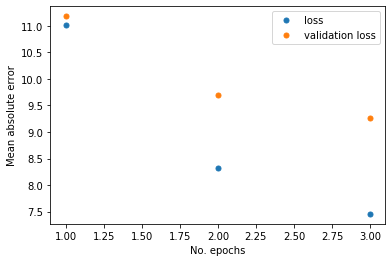

In [108]:
# plt.plot(range(1,epochs+1), history2d.history['loss'], label='loss',marker='.',
#          linestyle='none', markersize=10)
# plt.plot(range(1,epochs+1), history2d.history['val_loss'], label='validation loss', 
#          marker='.', linestyle='none',markersize=10)
# plt.ylabel('Mean absolute error')
# plt.xlabel('No. epochs')
# plt.legend()

# plt.show()

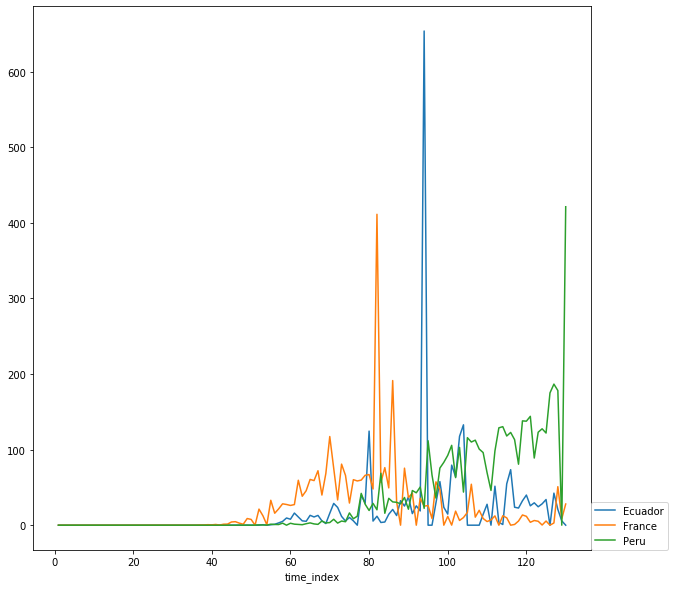

In [121]:
maxima_of_new_cases_weighted_series = data.set_index(['time_index','location']).new_cases_weighted.unstack().max().sort_values()[-3:].index
data.set_index(['time_index','location']).loc[pd.IndexSlice[:,maxima_of_new_cases_weighted_series],:].new_cases_weighted.unstack().plot(figsize=(10,10))
plt.legend(loc=(1,0))

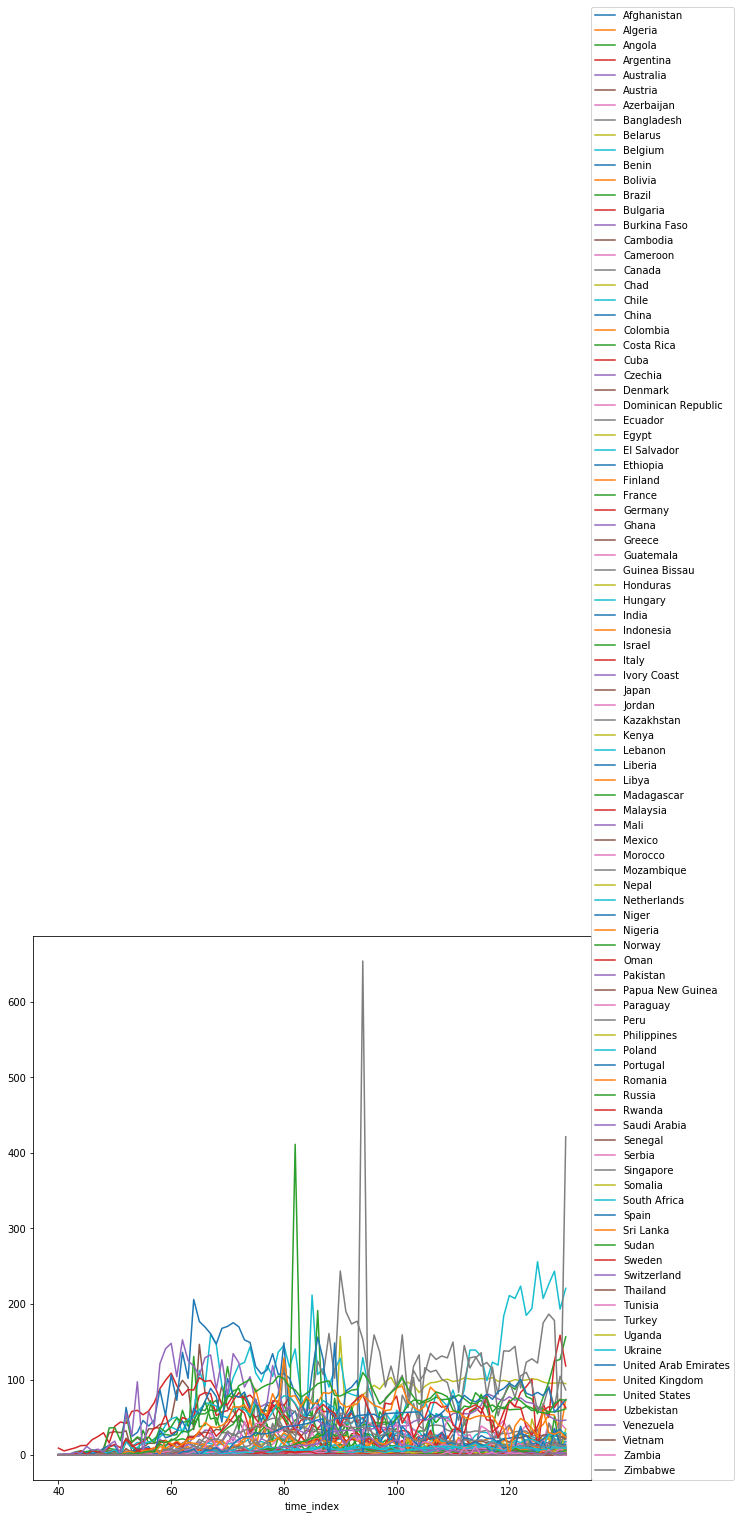

In [51]:
datatmp = data[data.time_index >= 40]
datatmp = datatmp[datatmp.location.isin(datatmp[datatmp.days_since_first_case > 60].location.unique())]
maxima_of_new_cases_weighted_series = datatmp.set_index(['time_index','location']).new_cases_weighted.unstack().max().sort_values().index
datatmp.set_index(['time_index','location']).loc[pd.IndexSlice[:,maxima_of_new_cases_weighted_series],:].new_cases_weighted.unstack().plot(legend=False,figsize=(10,10))
plt.legend(loc=(1,0))

In [242]:
datatmp = data[data.time_index >= 40]
datatmp = datatmp[datatmp.location.isin(datatmp[datatmp.days_since_first_case > 60].location.unique())]
model_data = datatmp.iloc[:,[1,2,3,4,5,-1]]
model_data

,time_index,days_since_first_case,new_cases_weighted,new_tests_weighted,new_deaths_weighted,stringency_index
39,40,6,0.000000,0.000000,0.0,19.44
40,41,7,0.000000,0.000000,0.0,22.22
41,42,8,0.000000,1.515605,0.0,22.22
42,43,9,0.000000,0.000000,0.0,22.22
43,44,10,0.000000,0.565141,0.0,22.22
...,...,...,...,...,...,...
17935,126,67,0.000000,0.000000,0.0,87.96
17936,127,68,5.113394,281.034819,0.0,87.96
17937,128,69,1.143785,108.794183,0.0,87.96
17938,129,70,0.000000,147.413763,0.0,87.96


In [191]:
ncountrylist = []
for n in range(0, 130):
    ncountrylist.append(data[data.days_since_first_case > n].location.nunique())

plt.plot(ncountrylist)

In [251]:
frame_size = 32
n_countries = datatmp.location.nunique()
start_date = frame_size + model_data.time_index.min()
n_validation_frames = 1
n_test_frames = 1
predict_steps = [1]
f = (8, 16)
k = (4, 4)
epochs = 3
batch_size = 128



# X, y = X[:-14,:,:,:], y[:-14,:]

Train on 5586 samples, validate on 98 samples
Epoch 1/3
5586/5586 [==============================] - 9s 2ms/sample - loss: 11.5051 - val_loss: 12.9718
Epoch 2/3
5586/5586 [==============================] - 1s 123us/sample - loss: 7.3951 - val_loss: 10.7473
Epoch 3/3
5586/5586 [==============================] - 1s 120us/sample - loss: 5.8864 - val_loss: 9.4146
1-step MAE [Naive, CNN] = [8.781193862072836,9.41458311906391]
1-step R^2 [Naive, CNN] = [0.32605329587441256,0.585863060822059]


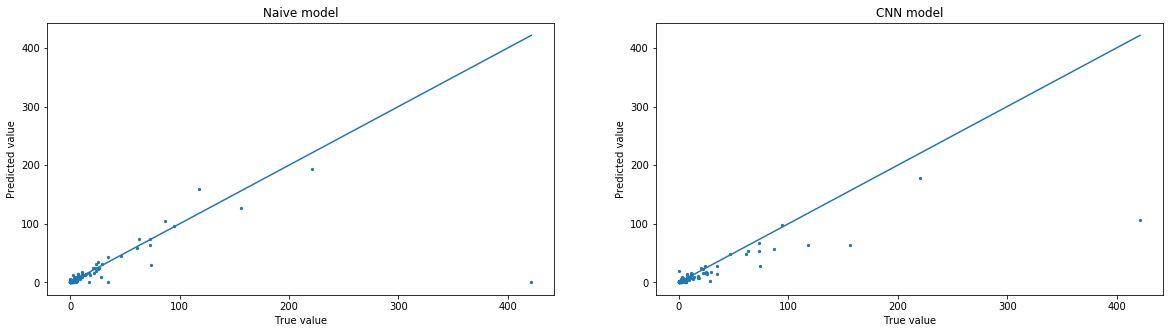

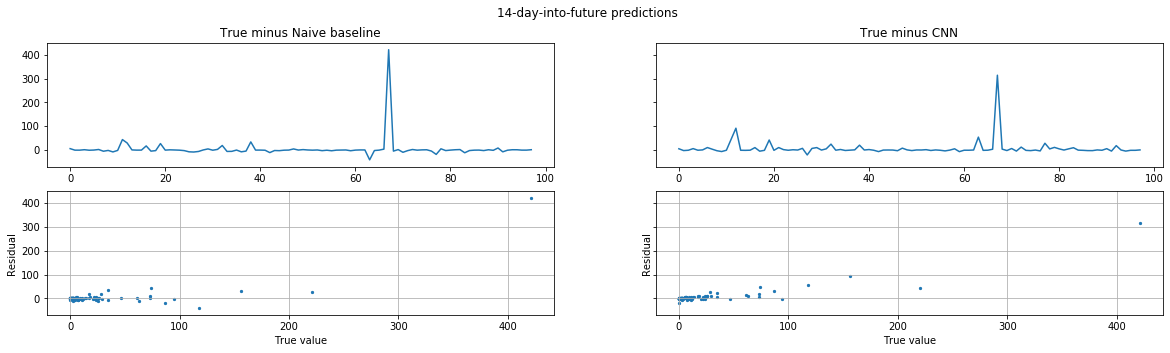

([], [], [], [], [])

In [253]:
my_model = sequential_Conv1D_model
n_step_model_predictions(model_data, my_model, frame_size, start_date, n_countries,
                             n_validation_frames, n_test_frames, predict_steps, f, k, epochs, batch_size)

If you have a convolution model. How is choosing a smaller frame size + kernel size different from
larger

In [ ]:
start_date = model_data.loc[model_data.days_since_first_case.idxmin(),'time_index'] + frame_size

In [162]:
model_data[model_data.time_index <= start_date]

,time_index,days_since_first_case,new_cases_weighted,new_tests_weighted,new_deaths_weighted,stringency_index
34,35,1,0.000000,0.0,0.0,0.00
35,36,2,0.000000,0.0,0.0,0.00
36,37,3,0.000000,0.0,0.0,0.00
37,38,4,0.000000,0.0,0.0,0.00
38,39,5,0.000000,0.0,0.0,0.00
...,...,...,...,...,...,...
17594,45,43,0.000000,0.0,0.0,47.22
17595,46,44,0.020547,0.0,0.0,47.22
17596,47,45,0.123281,0.0,0.0,47.22
17597,48,46,0.000000,0.0,0.0,47.22


In [166]:
model_data[model_data.time_index <= start_date].time_index.describe()

count    1438.000000
mean       32.321280
std        13.053489
min         2.000000
25%        22.000000
50%        36.000000
75%        44.000000
max        49.000000
Name: time_index, dtype: float64

In [ ]:
frame_data.values.reshape(-1, n_countries, frame_size, frame_data.shape[1])

In [161]:
# Take all model_data with date proxy less than numerical value, leading_window_date_not_included
frame_data = model_data[model_data.time_index <= start_date]
#     print(frame_data.shape)
# Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
reshaped_frame_data = frame_data.values.reshape(-1, n_countries, frame_size, frame_data.shape[1])

ValueError: cannot reshape array of size 8628 into shape (103,14,6)

The above model is the *only* one that hasn't underestimated values. There is still a lot of parameter tuning to be completed though:

The performance is the same up to small differences attributable to the individual trainings. 

In both models, the key difference between the predictions and the true values is that the ConvNet is having a hard
time picking up on dramatic spikes in the number of new cases. 

In [342]:
X, y = create_Xy(model_data, start_date, window_size, 20, n_countries)
list(X[-1:, :, -1, new_cases_weighted_index].ravel())[:5]

model_data[model_data.time_index == 129].new_cases_weighted.tolist()[:5]

X, y = create_Xy(model_data, start_date, window_size, 7, n_countries)
X[-1, -1, -1, :new_cases_weighted_index+1]

list(X7[-1, :, -1, 0].ravel())[:5]

model_data[model_data.time_index==129].iloc[:,2]

X1, y1 = create_Xy(model_data, start_date, window_size, 1, n_countries)
list(X1[-1, :, -7, new_cases_weighted_index].ravel()[:5])

X1.shape

y1.shape

model_data[model_data.time_index==129].iloc[:,2]

pd.Series(y1[-2,:].tolist())

X7, y7 = create_Xy(model_data, start_date, window_size, 7, n_countries)
list(X7[-1, :, -1, new_cases_weighted_index].ravel())[:5]

110


[20.08819230185021,
 4.446872563555672,
 0.0304263325547032,
 15.576676555422425,
 0.5882380392284968]

In [256]:
X[-n_test_frames:, :, -1, new_cases_weighted_index]

array([[8.96519068e+00, 4.37845914e+00, 0.00000000e+00, 7.21306329e+00,
        3.52942824e-01, 1.02149583e+01, 1.55831219e+01, 5.64699426e+00,
        1.00642152e+02, 2.97680268e+01, 0.00000000e+00, 2.13312243e+01,
        6.21943769e+01, 5.32493241e+00, 9.56787734e-02, 0.00000000e+00,
        0.00000000e+00, 3.30399770e+01, 2.80046237e+00, 9.86597290e+01,
        4.16862426e-03, 1.42091003e+01, 1.96304990e+00, 1.94232770e+00,
        4.57559832e+00, 1.15672741e+01, 3.42001552e+01, 7.34566453e+01,
        4.79799545e+00, 8.47953987e+00, 1.65269727e-01, 1.04679574e+01,
        0.00000000e+00, 6.19450421e+00, 3.12168673e+00, 8.63470368e-01,
        6.69808553e+00, 1.40868751e+01, 1.06011263e+01, 5.79689142e+00,
        3.52462648e+00, 1.93401944e+00, 2.19512564e+00, 1.44719409e+01,
        1.66803932e+00, 2.68824733e-01, 1.07809949e+00, 8.57445344e+00,
        9.11266791e-01, 1.61161724e+00, 7.90876918e-01, 1.45533144e-01,
        1.62507562e+00, 5.25242571e-01, 1.43203979e+00, 1.638063

In [324]:
y_true = y_test_A.ravel()
y_naive = X[-n_test_frames:, :, -1, new_cases_weighted_index].ravel()
y_predict = model.predict(
    [X_test_A, np.tile(X_test_B, (n_countries, 1,1,1))]).ravel()

If you have a convolution model. How is choosing a smaller frame size + kernel size different from
larger

switching the order of countries and timesteps affects the following:
reshape A
kernel size B
kernal size AB
concatenate axis 1->2